In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as vutils

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [3]:
batch_size = 128

workers = 20

nc = 3

nz = 100

ngf = 64

ndf = 64

train_transform = transforms.Compose([
                                     transforms.Resize((64,64)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.5,], [0.5,])])
preproccess = transforms.Compose([transforms.Normalize([0.5,], [0.5,])])

testtransform = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor(), transforms.Normalize([0.5,], [0.5,])])

data_path = 'A:\datasets\stanforddogs'

trainset = datasets.ImageFolder(data_path, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


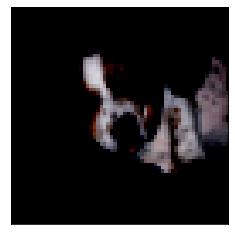

In [4]:
image, label = next(iter(trainloader))

def plot_img(array,number=None):
    array = array.detach()
    array = array.reshape(nc, 64,64)
    
    plt.imshow(array.permute(1, 2, 0) ,cmap='binary')
    plt.xticks([])
    plt.yticks([])
    if number:
        plt.xlabel(number,fontsize='x-large')
    plt.show()
    
    
def plot_imgs(imgs):
    imgs = imgs.detach()
    imgs = imgs.view(-1, nc, 64,64)
    
    stack_imgs = vutils.make_grid(imgs, nrow=8)
    
    plt.imshow(stack_imgs.permute(1, 2, 0),cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
plot_img(image[0])


In [5]:
def normal_init(m, mean, std):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input):
        return self.main(input)

In [6]:
G = Generator()
D = Discriminator()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.to(device)
D.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [7]:
criterion = nn.BCELoss()
#d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
#d_optimizer.zero_grad()
#g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)
#g_optimizer.zero_grad()

lr = 0.0002 
g_optimizer = optim.Adam(G.parameters(), lr = lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr = lr, betas=(0.5, 0.999))

epoch= 0
g loss= 5.943461072370873
d loss= 1.2768530414168635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


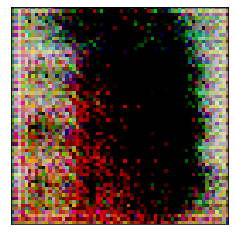

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


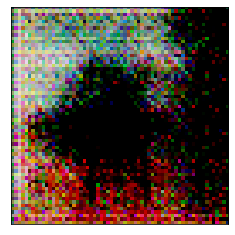




epoch= 5
g loss= 3.2845299584524974
d loss= 1.4195376739993413


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


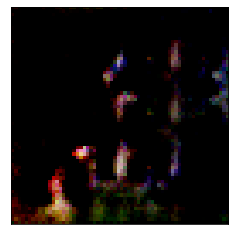

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


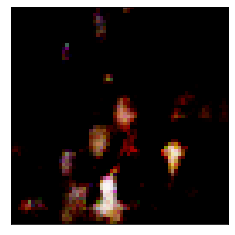




epoch= 10
g loss= 3.423497060070867
d loss= 1.141890212939763


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


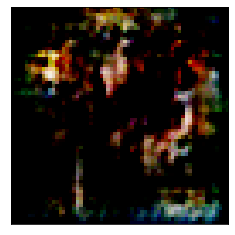

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


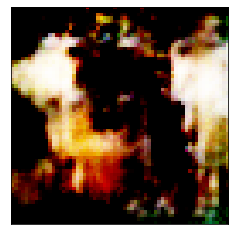




epoch= 15
g loss= 3.3145703373488433
d loss= 1.2278550665634713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


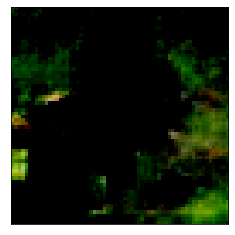

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


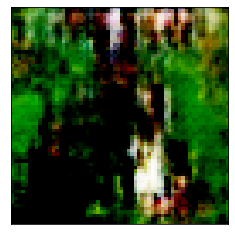




epoch= 20
g loss= 3.133023779006293
d loss= 1.1086278259334796


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


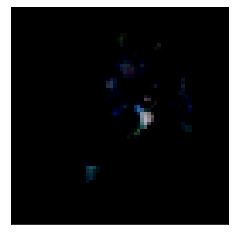

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


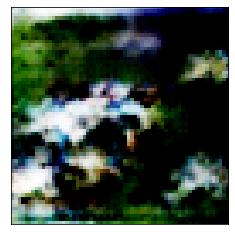




epoch= 25
g loss= 3.2142635965199204
d loss= 1.027524746480103


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


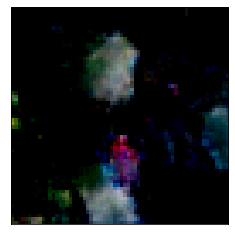

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


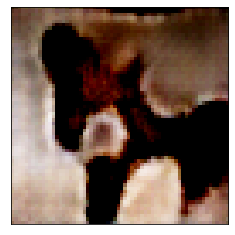




epoch= 30
g loss= 3.064342467982021
d loss= 1.105375030381686


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


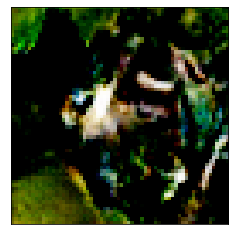

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


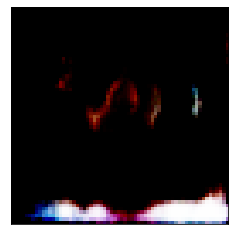




epoch= 35
g loss= 3.0575002172718877
d loss= 1.1070852355615044


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


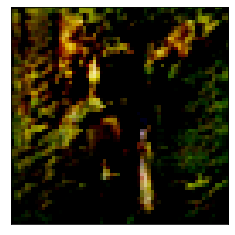

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


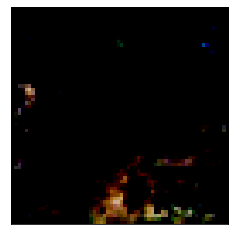

In [8]:
epochs = 40
printing_steps = 5

for e in range(epochs):
    running_g_loss = 0
    running_d_loss = 0
    for real_image, _ in trainloader:
        # Discrim Train
        D.zero_grad()
        real_image = real_image.to(device)
        real_out = D(real_image)
        dis_real_loss = criterion(real_out.squeeze(), Variable(torch.ones(real_out.shape[0])).to(device))
        running_d_loss += dis_real_loss.item()
        
        fake_image_in = torch.randn(batch_size,100, 1, 1).to(device)
        fake_image = G(fake_image_in)
        fake_out = D(fake_image.view(-1, nc, 64, 64))
        fake_loss = criterion(fake_out.squeeze(), Variable(torch.zeros(fake_out.shape[0])).to(device))
        #print(fake_loss)
        running_d_loss += fake_loss.item()
        
        loss = dis_real_loss + fake_loss
        loss.backward()
        d_optimizer.step()

        # Generator Training
        G.zero_grad()
            
        generator_input = torch.randn(batch_size,100, 1, 1).to(device)
        
        gen_out = G(generator_input)
        # print(gen_out.shape)
        dis_out_gen_train = D(gen_out.view(-1, nc, 64, 64))
        #print(dis_out_gen_train[:10])
        gen_loss = criterion(dis_out_gen_train.squeeze(), Variable(torch.ones(dis_out_gen_train.shape[0])).to(device))
        running_g_loss += gen_loss.item()
        gen_loss.backward()
        g_optimizer.step()
    if e%printing_steps == 0:
        print(f'epoch= {e}')
        print(f'g loss= {running_g_loss / len(trainloader)}')
        print(f'd loss= {running_d_loss / len(trainloader) * 2}')
        plot_img(gen_out[0].cpu())
        plot_img(gen_out[1].cpu())
        print("\n\n")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


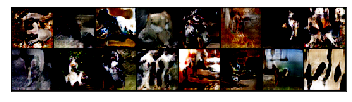

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


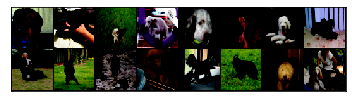

torch.Size([256, 3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


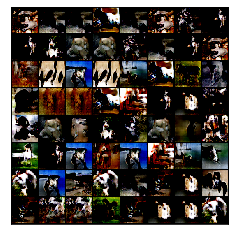

In [10]:
G.eval()

#print("fake images")
with torch.no_grad():
    generator_input = torch.randn(batch_size, 100, 1, 1).to(device)
    gen_out = G(generator_input).cpu()
    plot_imgs(gen_out[:16])

#print("real images")
image, label = next(iter(trainloader))
plot_imgs(image[:16])

#print("blended images")
gen_out = gen_out.view(-1, nc, 64, 64)
combined = torch.cat((gen_out, image), dim=0)
print(combined.shape)
np.random.shuffle(combined)

plot_imgs(combined[:64])

In [11]:
D_PATH = 'Sdogs_3channel_D.pwf'
torch.save(D.state_dict(), D_PATH)
G_PATH = 'Sdogs_3channel_G.pwf'
torch.save(G.state_dict(), G_PATH)

In [ ]:
D_PATH = 'mnist_dcgan_D.pwf'
D.load_state_dict(torch.load(D_PATH))
G_PATH = 'mnist_dcgan_G.pwf'
G.load_state_dict(torch.load(G_PATH))